In [1]:
# Imports
import pandas as pd
import itertools
import networkx as nx
import requests, sys
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import sklearn.cluster as skcluster
import sklearn.mixture as skmixture
import math
import utils

# User-set variables
SIMILARITY_THRESHOLD = .5 # For deciding to cluster two promoters when using Ratcliff-Obershelp similarity

In [2]:
# Helpers
def openness_dict(file):
    df = pd.read_csv(file)
    out_dict = {}
    for i, row in df.iterrows():
        gene_id = row['gene_id']
        a_t = row['A_g_max']
        out_dict[gene_id] = a_t
    return out_dict

def prune():
    gene_ids = sorted(rep1_48)
    for gene in gene_ids:
        if rep1_48[gene] == 0 and rep2_48[gene] == 0 and rep3_48[gene] == 0 and rep1_72[gene] == 0 and rep2_72[gene] == 0 and rep3_72[gene] == 0:
            del rep1_48[gene]
            del rep2_48[gene]
            del rep3_48[gene]
            del rep1_72[gene]
            del rep2_72[gene]
            del rep3_72[gene]

# Move to helpers file
conversions = pd.read_csv('fbgn_annotation_ID_fb_2020_04.tsv', sep='\t', header=0)
def FBgn_to_entrez(FBgn):
    try:
        entrez = conversions[conversions['primary_FBgn#'] == FBgn]['gene_symbol'].iloc[0]
    except:
        try:
            entrez = conversions[conversions['secondary_FBgn#(s)'] == FBgn]['gene_symbol'].iloc[0]
        except:
            entrez = FBgn
    return entrez

# Replace with non-REST one
def promoter_dict(fbgns):
    df = pd.read_csv('promoter_similarity_seqs.csv')
    out_dict = {}
    for fbgn in tqdm(fbgns):
        try:
            out_dict[fbgn] = df[df['gene_id'] == fbgn].iloc[0]['sequence'] #promoter_seq
        except:
            continue
    return out_dict

def aggregate_openness_scores(rep, components):
    rep_avg = []
    rep_sum = []
    for component in components:
        o_scores = [rep[fbgn] if fbgn in rep.keys() else 0 for fbgn in component]
        summation = sum(o_scores)
        average = summation/len(o_scores)
        rep_avg.append(average)
        rep_sum.append(summation)
    return rep_avg, rep_sum

In [3]:
# Load openness data
rep1_48 = openness_dict('Openness output/500promoter500gene_48hr_rep1.csv')
rep2_48 = openness_dict('Openness output/500promoter500gene_48hr_rep2.csv')
rep3_48 = openness_dict('Openness output/500promoter500gene_48hr_rep3.csv')
rep1_72 = openness_dict('Openness output/500promoter500gene_72hr_rep1.csv')
rep2_72 = openness_dict('Openness output/500promoter500gene_72hr_rep2.csv')
rep3_72 = openness_dict('Openness output/500promoter500gene_72hr_rep3.csv')
prune()
gene_ids = sorted(rep1_48)

KeyboardInterrupt: 

In [ ]:
# Load promoter data
promoters = promoter_dict(gene_ids) # {FBgn: promoter sequence}
gene_ids = sorted(promoters.keys())

# Ratcliff-Obershelp Sequence Similarity Clusters

In [6]:
# Analyze promoters for Ratcliff-Obershelp similarity
adj_list = {fbgn: [] for fbgn in gene_ids} # {FBgn: [FBgns with similar promoters]}
pairs = list(itertools.combinations(gene_ids, 2))
for p1, p2 in tqdm(pairs):
    similarity = utils.sequence_similarity(promoters[p1], promoters[p2])
    if similarity >= SIMILARITY_THRESHOLD:
        adj_list[p1].append(p2)

100%|██████████| 183921/183921 [21:00<00:00, 145.96it/s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


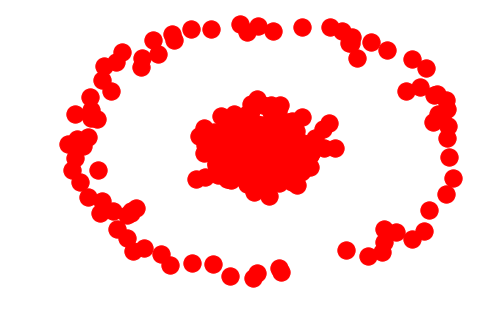

In [9]:
# Load the adjacency list to a NetworkX graph
G = nx.from_dict_of_lists(adj_list)
nx.draw(G)
plt.show()

# Find the components of the network; each component will be 1 weight?
# We can adjust using the similarity threshold to create more or less edges
# We will end up with groups of genes with similar promoters
components = list(nx.connected_components(G))

In [76]:
# The size of each component, and the number of components
for c in components:
    print(len(c))
len(components)

522
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


79

# Scikit Clustering

In [5]:
features = np.array([utils.seq_to_vec(promoters[gene]) for gene in promoters.keys()])
features = features.reshape(607, 240)
#sk.cluster.dbscan(features) # Says every promoter is too noisy
#sk.cluster.mean_shift(features, bandwidth=sk.cluster.estimate_bandwidth(features)) # Every promoter is in the same category
#sk.cluster.ward_tree(features)
k = 79
centers, labels, inertia = skcluster.k_means(features, k)

In [74]:
# Number of genes in each cluster
labels_dict = {n: 0 for n in range(k)}
for label in labels:
    labels_dict[label] += 1
labels_dict

{0: 6,
 1: 14,
 2: 10,
 3: 13,
 4: 10,
 5: 7,
 6: 8,
 7: 21,
 8: 10,
 9: 15,
 10: 11,
 11: 6,
 12: 9,
 13: 5,
 14: 8,
 15: 13,
 16: 10,
 17: 11,
 18: 10,
 19: 8,
 20: 9,
 21: 6,
 22: 7,
 23: 8,
 24: 9,
 25: 8,
 26: 6,
 27: 9,
 28: 4,
 29: 9,
 30: 9,
 31: 6,
 32: 8,
 33: 8,
 34: 7,
 35: 11,
 36: 8,
 37: 10,
 38: 4,
 39: 7,
 40: 6,
 41: 9,
 42: 6,
 43: 6,
 44: 14,
 45: 3,
 46: 7,
 47: 8,
 48: 11,
 49: 7,
 50: 7,
 51: 8,
 52: 8,
 53: 8,
 54: 5,
 55: 4,
 56: 6,
 57: 6,
 58: 11,
 59: 7,
 60: 7,
 61: 4,
 62: 6,
 63: 6,
 64: 3,
 65: 8,
 66: 7,
 67: 8,
 68: 9,
 69: 2,
 70: 6,
 71: 4,
 72: 5,
 73: 3,
 74: 5,
 75: 5,
 76: 5,
 77: 4,
 78: 5}

In [78]:
center_dict = {}
for center in centers:
    center = [center[i:i + 4] for i in range(0, len(center), 4)]
    vec = []
    for quad in center:
        one = list(quad).index(max(quad))
        one_hot = [0, 0, 0, 0]
        one_hot[one] = 1
        vec += one_hot
    seq = utils.vec_to_seq(vec)
    try:
        center_dict[seq] += 1
    except:
        center_dict[seq] = 1
center_dict

{'AAACAAGGGGCGACAACCCTCCGTATTAAAGCAGTAGCGCGATGCCAGTGAGAGAGAGGG': 1,
 'ACGCGGTAGCATACCGAAAGGTAAAAAAAAATTCCCCAGTTATCGCTGTCAGTGTCAAGT': 1,
 'GATAGTTTTAAACTTTCAATATCAAAGTCAAAAGACAAATAGGAAAAGTCAACGATAGCA': 1,
 'CAACTGACAAAAAGTATTGCAGTAGAGAGGTGAAATTCCGCGATAACGTCAGTTCTTTTT': 1,
 'TAATTAAACATTCATTGACATATAAAAGCTTGTTCTAACAGTATTAAATCAGTTTTTTTT': 1,
 'ACAGTTTGTAGCGGACATATAGTCGGTCGAGAGCGTCAGCTGTAGCGATCAGTTTGTTTT': 1,
 'AGTTATATGATTGCGGTCACTTGTTCGATATACACTTTAGGCGATTTGTCAGTGTGGTTA': 1,
 'TTTGCACTACACTAACACTAGACGGTCGTCGCTGTGATATAAAAAAGGTCAGTATAAAAA': 1,
 'TGTATGGTTTCCAACACCCGTGGCCAACATTTGAATTTCCAATTGCTTTCAGTCTTTTTT': 1,
 'AATAAAAAGCGACAACGTGATGAATTTCAATGTGATGGGCAACGTCGGTAAAAAAAACAC': 1,
 'TTGATGCTCCGGCTTTTGCATTGTCTCGGTGGCGGCGGTAACTAGGTATCAATTTATTTT': 1,
 'AGCGACAGTGAGTAGGTATTTTTGGGTACGGTAGCGTCCCGAAAACAATCAGAAAGAAAA': 1,
 'TAATTATGGACAACAGACTTTCAGATTTCTGTCGATAATATATACCAATCACACTAAATA': 1,
 'ACCATTTCAAATTTTAAAGCTAGTCTGGTGCTGTGAACAAGGTAAAGATCAAATAAAAAC': 1,
 'GCGATAAATATGCGTGAGATATACCCTGTACCACCGTTGAGACCAT

In [6]:
clusters = {n: [] for n in range(k)}
for i, label in enumerate(labels):
    seq = utils.vec_to_seq(features[i])
    fbgn = list(promoters.keys())[list(promoters.values()).index(seq)]
    clusters[label].append(fbgn)
components = [clusters[cluster] for cluster in clusters.keys()]
len(components[0])

4

# Linear Regression Model

In [10]:
# Make sure you have 'components' variable defined, either by clustering or sequence similarity

# Aggregate the openness scores among the genes in each group -> a new sized a(t) vector
# There will be one for each replication
rep1_avg, rep1_sum = aggregate_openness_scores(rep1_48, components)
rep2_avg, rep2_sum = aggregate_openness_scores(rep2_48, components)
rep3_avg, rep3_sum = aggregate_openness_scores(rep3_48, components)
sum_lists = [rep1_sum, rep2_sum, rep3_sum]

In [11]:
gene = 'FBgn0050452' # FBgn0011958 - in both time steps, FBgn0050452 - in 48 only, FBgn0011881 - in 72 only
x = [rep1_avg+[1], rep2_avg+[1], rep3_avg+[1]]
y = [rep1_72[gene], rep2_72[gene], rep3_72[gene]]

In [12]:
A = np.vstack(x).T
result = np.linalg.lstsq(x, y, rcond=None)[0]
result, result.shape

(array([-8.70776887e-03,  0.00000000e+00,  1.01714741e-02,  0.00000000e+00,
        -2.31794417e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.35970357e-02,  6.31949689e-03, -2.78452329e-03,  2.84242590e-04,
         0.00000000e+00,  1.55598314e-03,  6.99089749e-03, -5.99443966e-03,
        -4.05419111e-02, -7.23610090e-02, -1.16572690e-03,  1.58685777e-02,
        -5.89953694e-02, -6.69449896e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.28126600e-03,  0.00000000e+00,  0.00000000e+00,
        -2.40918155e-02,  0.00000000e+00,  8.82132176e-04,  3.05193229e-03,
         0.00000000e+00,  1.96458187e-02,  1.56088388e-02,  4.04310580e-03,
         0.00000000e+00,  0.00000000e+00,  2.25887096e-02, -2.75051339e-02,
         3.05609791e-02, -7.75764852e-03, -1.75536436e-04,  0.00000000e+00,
         1.22763394e-03,  0.00000000e+00, -1.02172422e-02,  0.00000000e+00,
         0.00000000e+00,  1.31989027e-02, -1.88506063e-01, -8.52688252e-02,
        -4.0

In [14]:
# Predicted Y: w_i*sum(openness scores within a component) summed for each weight w_i plus intercept
gene_at_48 = [rep1_48[gene], rep2_48[gene], rep3_48[gene]]
pred_y = [sum([result[j]*sum_lists[i][j] for j, avg_openness in enumerate(X[:-1])]) + result[-1] for i, X in enumerate(x)]
gene_at_48, y, pred_y

([0.05549, 0.305181, 0.0],
 [0.272162, 0.261063, 0.17504],
 [0.25188070032056026, 0.24274801778212637, 0.12643864973319252])

In [18]:
sq_errs = [(y[i]-pred_y[i])**2 for i in range(3)]
sum(sq_errs), sum(sq_errs)/3, max(sq_errs)

(0.0031088609380851774, 0.0010362869793617258, 0.0023620912477569076)

# Graphing performance of k-means

In [5]:
x = range(1, 101) # k value
y = [] # sum of square errors
gene = 'FBgn0050452' # FBgn0011958 - in both time steps, FBgn0050452 - in 48 only, FBgn0011881 - in 72 only

In [6]:
for k in tqdm(x):
    features = np.array([utils.seq_to_vec(promoters[gene]) for gene in promoters.keys()])
    features = features.reshape(607, 240)
    centers, labels, inertia = skcluster.k_means(features, k)
    
    clusters = {n: [] for n in range(k)}
    for i, label in enumerate(labels):
        seq = utils.vec_to_seq(features[i])
        fbgn = list(promoters.keys())[list(promoters.values()).index(seq)]
        clusters[label].append(fbgn)
    components = [clusters[cluster] for cluster in clusters.keys()]
    
    rep1_avg, rep1_sum = aggregate_openness_scores(rep1_48, components)
    rep2_avg, rep2_sum = aggregate_openness_scores(rep2_48, components)
    rep3_avg, rep3_sum = aggregate_openness_scores(rep3_48, components)
    sum_lists = [rep1_sum, rep2_sum, rep3_sum]
    
    x_LR = [rep1_avg+[1], rep2_avg+[1], rep3_avg+[1]]
    y_LR = [rep1_72[gene], rep2_72[gene], rep3_72[gene]]
    
    A = np.vstack(x_LR).T
    result = np.linalg.lstsq(x_LR, y_LR, rcond=None)[0]
    
    preds = [sum([result[j]*sum_lists[i][j] for j, avg_openness in enumerate(X[:-1])]) + result[-1] for i, X in enumerate(x_LR)]
    sum_sq_err = sum([(y_LR[i] - preds[i])**2 for i in range(3)])/3
    y.append(sum_sq_err)

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


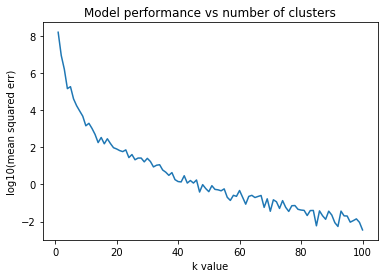

In [7]:
plt.xlabel('k value')
plt.ylabel('log10(mean squared err)')
plt.title('Model performance vs number of clusters')
plt.plot(x, [math.log(Y) for Y in y])

In [106]:
x[2], y[2]

(3, 1278.3160834305345)

In [7]:
len(gene_ids)

607

# Motifs in clustered promoters

In [92]:
k = 4
base_threshold = .5

features = np.array([utils.seq_to_vec(promoters[gene]) for gene in promoters.keys()])
features = features.reshape(607, 240)
centers, labels, inertia = skcluster.k_means(features, k)

In [93]:
center_seqs = []
for center in centers:
    center = [center[i:i + 4] for i in range(0, len(center), 4)]
    vec = []
    for quad in center:
        one = list(quad).index(max(quad))
        one_hot = [0, 0, 0, 0]
        one_hot[one] = 1 if max(quad) >= base_threshold else 2
        vec += one_hot
    seq = utils.vec_to_seq(vec)
    center_seqs.append(seq)
center_seqs

['-----------------------------------------------ATT-----T----',
 '------------------------------------------------T-A-A---AA--',
 '----------------------------------------------AGT-A-A-------',
 '------------------------------------------------TCAGT-------']